In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import os
from importlib import reload

In [28]:
import dataset_utils
from glob import glob

In [29]:
reload(dataset_utils)

<module 'dataset_utils' from '/Users/katiezhou/P4P-mmWave/MMWave_Radar_Human_Tracking_and_Fall_detection/dataset_utils.py'>

In [5]:
bg_noise_dir = './data/03_09_2024_katie_pc_bg_noise/unique_bg_points.pkl'
with open(bg_noise_dir, 'rb') as file:
        background_data = pickle.load(file)

In [30]:
def background_subtraction(background_data, current_frame_data, threshold=0.1):
    filtered_data = []
    points_removed = []
    num_points_removed = 0
    for point in current_frame_data:
        # print(point)
        distances = np.linalg.norm(background_data[:, :3]- point[:3], axis =1)
        # filtered_data.append(point)
        if np.min(distances) > threshold:
            filtered_data.append(point)
        else:
            filtered_data.append([0,0,0,0,0])
            points_removed.append(point)
    return filtered_data

In [7]:
def parse_dataset(num_points, DATA_DIR):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob(os.path.join(folder, "train/*"))
        test_files = glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points_sample = []
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    train_points_sample.append(bg_rm_arr)
                train_points_sample = np.array(train_points_sample).reshape(-1,5)
                train_points.append(train_points_sample)
                train_labels.append(i)
               
        
        for f in test_files:
            test_points_sample = []
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    test_points_sample.append(bg_rm_arr)
                test_points_sample = np.array(test_points_sample).reshape(-1,5)
                test_points.append(test_points_sample)
                test_labels.append(i)
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [8]:
DATA_DIR = "cluster_data/padded"
NUM_POINTS = 300
NUM_FRAMES = 3
NUM_CLASSES = 4
train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS, DATA_DIR)

# Verify the shapes
print(f"train_points shape: {train_points.shape}")
print(f"test_points shape: {test_points.shape}")
print(f"train_labels shape: {np.array(train_labels).shape}")
print(f"test_labels shape: {np.array(test_labels).shape}")

processing class: walking
processing class: picking_up
processing class: jumping
processing class: sitting
train_points shape: (1393, 300, 5)
test_points shape: (349, 300, 5)
train_labels shape: (1393,)
test_labels shape: (349,)


In [44]:
# from sklearn.model_selection import train_test_split
# train_data, val_data, train_labels, val_labels = train_test_split(
#     train_points, train_labels, test_size=0.2, random_state=42, shuffle=True)

# train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
# train_dataset = tf.data.Dataset.from_tensor_slices()

In [9]:
print(CLASS_MAP)

{0: 'walking', 1: 'picking_up', 2: 'jumping', 3: 'sitting'}


In [10]:
from tensorflow import data as tf_data
import keras
import PointNET

keras.utils.set_random_seed(seed=42)

In [11]:
train_size = 0.8
seed = 42
BATCH_SIZE = 32
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))

train_dataset_size = int(len(dataset) * train_size)

# dataset = dataset.shuffle(len(train_points), seed=seed).map(PointNET.augment)

dataset = dataset.shuffle(len(train_points), seed=seed)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

In [12]:
import keras
import tensorflow as tf
from keras import ops
from keras import layers
from PointNET import tnet, conv_bn, dense_bn
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer

In [25]:
import tensorflow as tf
from tensorflow import data as tf_data
import keras
from keras import layers
import numpy as np

keras.utils.set_random_seed(seed=42)

def create_pointnet_model(input_shape, num_features, NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)

    # PointNet feature extraction
    x = tnet(inputs, num_features)
    
    # Convolutional layers
    x = conv_bn(x, 64)
    x = conv_bn(x, 64)
    x = conv_bn(x, 128)
    x = conv_bn(x, 1024)
    
    # GlobalMaxPooling1D
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Reshape((-1, 1024))(x)
    
    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Flatten()(x)
    # Fully connected layer
    x = layers.Dense(256, activation='relu')(x)
    
    # Final dense layer
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet_lstm")
    return model

# Usage
input_shape = (None, 300, 5)  # Adjust this based on your input data
num_features = 5  # Features per point (R, v, x, y, SNR, in, if)



In [26]:

model = create_pointnet_model(input_shape, num_features, NUM_CLASSES=4)
model.summary()

ValueError: Kernel shape must have the same length as input, but received kernel of shape (1, 5, 32) and input of shape (None, 10, 30, 5).

In [118]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os


In [119]:
INIT_TIMESTAMP = "4_10_2024_testing_complete_data_no_bg_rm"
checkpoint_dir = os.path.join('model/checkpoints/', INIT_TIMESTAMP)
os.makedirs(checkpoint_dir, exist_ok=True)

In [120]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [121]:
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best.weights.h5'),  # Save weights after each epoch
    save_weights_only=True,  # Save only weights, not the entire model
    save_best_only = True,
    verbose=1  # Print a message when saving
)

In [122]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks= [ checkpoint_callback, early_stopping_callback]  
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 6.6429 - sparse_categorical_accuracy: 0.3911
Epoch 1: val_loss improved from inf to 5.02110, saving model to model/checkpoints/2_10_2024_testing_complete_data/best.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - loss: 6.6157 - sparse_categorical_accuracy: 0.3937 - val_loss: 5.0211 - val_sparse_categorical_accuracy: 0.5699
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 4.9108 - sparse_categorical_accuracy: 0.6982
Epoch 2: val_loss improved from 5.02110 to 4.49451, saving model to model/checkpoints/2_10_2024_testing_complete_data/best.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - loss: 4.9082 - sparse_categorical_accuracy: 0.6991 - val_loss: 4.4945 - val_sparse_categorical_accuracy: 0.8100
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 4.7615 - sparse_categorical_accuracy: 0.7691
Epoch 3: val_loss improved from 4.49451 to 4.41816, saving model to model/checkpoints/2_10_2024_testing_com

In [123]:
from matplotlib import pyplot as plt


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
[[[-6.90917969e-01  1.32128906e+00  1.08593750e+00 -1.25244141e-01
    2.99000000e+02]
  [-6.36230469e-01  1.26171875e+00  1.02734375e+00 -1.25244141e-01
    2.64000000e+02]
  [-6.27929688e-01  1.43847656e+00  1.09765625e+00 -1.25244141e-01
    2.08000000e+02]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]]

 [[ 1.95312500e-03  1.24218750e+00  6.76757812e-01  0.00000000e+00
    1.82000000e+02]
  [ 1.81640625e-01  1.33105469e+00  9.35546875e-01  0.00000000e+00
    1.90000000e+02]
  [-3.51562500e-02  1.33496094e+00  6.13281250e-01  0.00000000e+00
    2.20000000e+02]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000

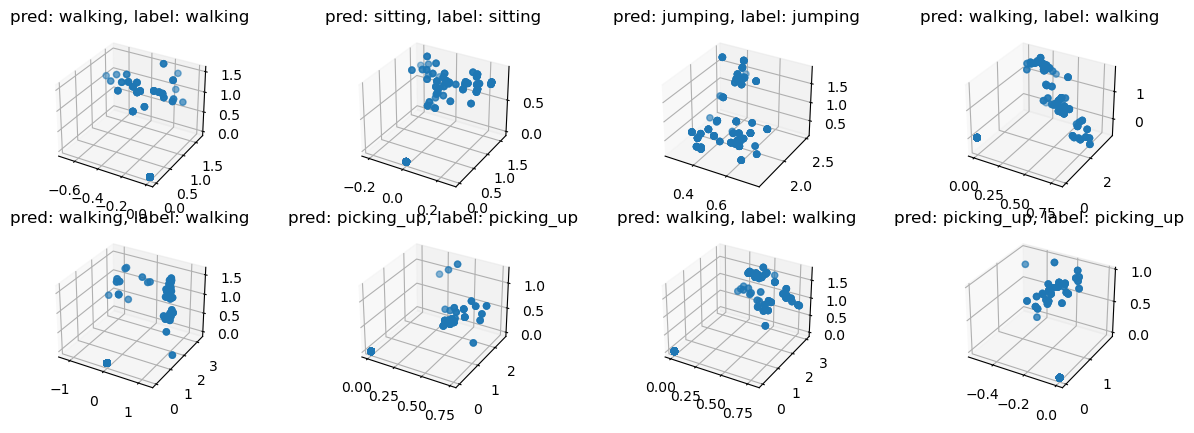

In [145]:
data = train_dataset.take(1)

points, labels = list(data)[0]
points = points[:20, ...]
labels = labels[:20, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()
preds = preds.numpy()
labels = labels.numpy()
print(points)

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
num_points_to_plot = min(len(points), 8)

for i in range(num_points_to_plot):  # Update to use num_points_to_plot
    ax = fig.add_subplot(4, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    
    # Set title with prediction and label
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i]], CLASS_MAP[labels[i]]
        )
    )

    
    ax.set_axis_on()
plt.show()

In [125]:
predictions = []

# Calculate the number of sections, ensure it's at least 1
num_sections = max(1, len(test_points) // NUM_POINTS)

for batch in np.array_split(test_points, num_sections): 
    preds = model.predict(batch)
    print("pred is", preds)
    print(batch.shape)
    preds = np.argmax(preds, axis=-1)
    print("argmax is", preds)
    predictions.extend(preds)

predictions = np.array(predictions)
accuracy = np.sum(predictions == test_labels) / len(predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
pred is [[9.9620837e-01 2.4881065e-03 8.6587615e-04 4.3776643e-04]
 [9.9668169e-01 2.0861330e-03 8.5111457e-04 3.8114528e-04]
 [9.8699337e-01 9.9211484e-03 1.2664020e-03 1.8190828e-03]
 ...
 [8.1203952e-03 7.9015503e-03 3.3941118e-03 9.8058397e-01]
 [6.8143727e-03 8.1212446e-03 3.3689016e-03 9.8169559e-01]
 [6.4853877e-03 9.5811719e-03 3.4064667e-03 9.8052692e-01]]
(349, 300, 5)
argmax is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 3 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 3 1 1 1 1 1 1 0 2 2 2 2 2 2 0 2 2 2 2 2 0 2 2 2 2 0 2 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 1 2 2
 2 1 2 2 0 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 

In [16]:
BATCH_SIZE = 32
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
test_dataset = test_dataset.shuffle(len(test_points), seed=seed).batch(BATCH_SIZE)


In [17]:
predictions = []
true_labels = []

# Iterate over the test_dataset to make predictions
for batch, labels in test_dataset:
    for sample, label in zip(batch, labels):
        sample = np.expand_dims(sample, axis=0)  # Add batch dimension
        preds = reload_model.predict(sample)  # Make a prediction
        preds = np.argmax(preds, axis=-1)  # Get the class with the highest probability
        
        predictions.extend(preds)  # Extend the predictions list
        true_labels.extend([label.numpy()])  # Append the true label (not extend)

# Convert to numpy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

2024-10-03 16:31:20.447887: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
print(len(predictions))

349


In [19]:
print(len(true_labels))

349


In [20]:
print(test_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 300, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [21]:
accuracy = np.sum(predictions == true_labels) / len(true_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 92.26%


In [22]:
print(predictions)

[3 1 1 2 1 3 1 0 0 1 3 0 0 0 0 1 1 0 3 2 0 0 1 3 0 3 0 1 0 0 0 3 2 0 0 0 2
 0 0 0 0 2 2 0 2 0 1 2 3 0 0 3 0 0 3 1 0 2 0 3 1 0 3 0 2 1 1 1 1 0 0 0 0 2
 3 2 0 0 3 1 1 3 0 1 2 0 3 0 1 3 2 1 0 2 1 0 1 0 0 1 0 3 3 0 0 2 1 3 1 2 0
 1 2 1 0 0 2 1 3 2 2 3 1 2 3 1 3 3 0 1 3 3 0 0 0 2 3 2 0 1 0 2 2 1 3 0 3 1
 0 2 1 0 0 3 2 1 0 3 0 0 3 3 2 1 3 3 2 2 3 3 2 3 3 1 0 3 0 1 1 3 1 1 1 3 0
 2 2 1 0 0 2 0 2 2 0 0 0 3 2 2 3 3 3 0 0 1 1 0 0 0 0 2 0 2 0 0 0 2 2 2 0 0
 0 2 1 0 0 3 0 3 1 2 0 1 0 2 0 3 1 0 0 3 1 1 1 0 3 0 0 0 0 0 0 2 1 0 2 3 0
 2 3 3 2 2 0 0 1 2 2 0 1 1 0 2 3 1 0 3 0 2 0 3 1 1 2 2 0 3 2 3 2 3 0 0 1 1
 0 0 0 1 0 2 0 0 1 0 3 2 1 1 0 2 3 0 2 2 0 2 0 1 3 2 1 3 1 0 2 1 1 0 1 1 2
 2 0 3 1 1 1 1 0 0 1 3 1 0 0 0 2]


In [23]:
print(true_labels)

[3 1 1 2 1 3 1 2 0 2 3 0 0 0 0 1 1 0 3 2 0 0 1 3 0 3 0 1 0 0 0 3 2 0 0 0 2
 1 0 0 0 2 2 0 2 0 1 2 3 1 0 3 0 0 3 1 0 2 0 3 1 0 3 0 2 1 1 1 3 0 2 0 2 1
 3 2 0 0 3 1 1 3 0 1 2 0 3 0 1 3 2 0 0 2 3 0 1 0 0 1 0 3 3 0 0 2 1 3 1 2 0
 1 2 3 0 0 2 1 3 2 2 3 1 2 3 1 3 3 0 1 3 3 3 0 0 2 0 2 0 1 0 2 2 1 3 0 3 1
 1 2 2 0 2 3 2 1 0 3 2 0 3 3 2 1 3 3 0 2 3 3 2 3 3 1 0 3 0 1 1 3 1 1 1 3 1
 2 2 1 0 0 2 0 2 2 0 0 0 3 2 2 3 3 3 0 0 1 1 1 0 0 0 2 0 2 0 0 0 2 2 2 0 0
 0 2 1 0 0 3 0 3 1 2 0 1 0 2 0 3 1 0 0 3 1 1 1 0 3 0 2 0 0 0 0 2 1 0 2 3 0
 2 3 3 2 2 0 0 1 2 2 0 1 1 0 2 3 1 0 3 0 2 0 3 1 1 2 2 0 1 2 3 2 1 0 2 1 1
 0 0 0 2 0 2 0 0 1 0 3 2 1 1 0 2 3 0 2 2 0 2 3 1 3 2 1 3 1 0 2 1 1 0 1 2 2
 2 0 3 1 1 1 1 0 0 1 3 1 0 0 0 2]


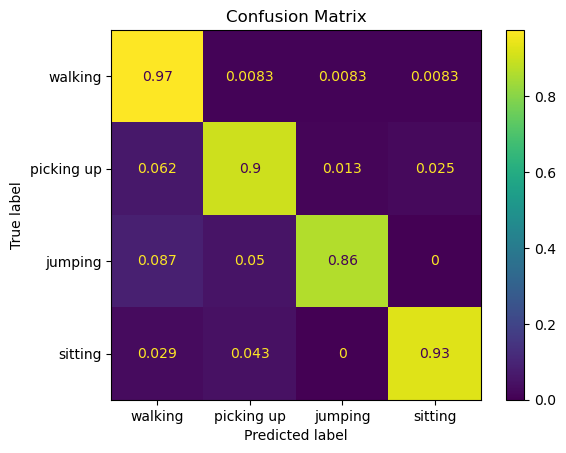

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plotting the confusion matrix
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# Plotting the confusion matrix
class_names = ['walking', 'picking up', 'jumping', 'sitting']  # Based on your CLASS_MAP
# class_names = ['jumping','picking up','sitting','walking']
disp = ConfusionMatrixDisplay(cm_normalized, display_labels=class_names)

# Display the plot
disp.plot()
plt.title("Confusion Matrix")
plt.show()


In [15]:
#reload model
reload_model = create_pointnet_model(input_shape, num_features, NUM_CLASSES=4)
reload_model.load_weights('./model/checkpoints/2_10_2024_testing_complete_data/best.weights.h5')

In [136]:
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
test_dataset = test_dataset.shuffle(len(test_points), seed=seed).batch(1)

In [137]:
predictions = []
true_label = []

# Iterate over the test_dataset to make predictions
for batch, label in test_dataset:
    preds = reload_model.predict(batch)  # Get predictions for the current batch
    print("pred is", preds)
    print(batch.shape)
    preds = np.argmax(preds, axis=-1)  # Get the class with the highest probability
    print("argmax is", preds)
    predictions.extend(preds)  # Extend the predictions list with the results
    true_label.extend(label)

true_label = np.array(true_label)
predictions = np.array(predictions)  # Convert predictions to a numpy array


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
pred is [[0.00671438 0.00827959 0.00321835 0.9817877 ]]
(1, 300, 5)
argmax is [3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
pred is [[0.01040098 0.927539   0.05598499 0.00607497]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
pred is [[0.00412879 0.9695383  0.01012757 0.01620535]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
pred is [[0.09456151 0.01246786 0.89197135 0.00099932]]
(1, 300, 5)
argmax is [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
pred is [[0.11458556 0.8547244  0.01576693 0.01492311]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
pred is [[0.12095322 0.03185787 0.00930571 0.8378832 ]]
(1, 300, 5)
argmax is [3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
pred is [[0.00516009 0.97189    0.01498289 0.00796701]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
pred is [[0.8050041  0.00971975 0.18220145 0.00307476]]
(1, 300, 5)
argmax is [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
p

In [138]:
accuracy = np.sum(predictions == true_label) / len(true_label)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 92.26%


In [139]:
print(predictions)

[3 1 1 2 1 3 1 0 0 1 3 0 0 0 0 1 1 0 3 2 0 0 1 3 0 3 0 1 0 0 0 3 2 0 0 0 2
 0 0 0 0 2 2 0 2 0 1 2 3 0 0 3 0 0 3 1 0 2 0 3 1 0 3 0 2 1 1 1 1 0 0 0 0 2
 3 2 0 0 3 1 1 3 0 1 2 0 3 0 1 3 2 1 0 2 1 0 1 0 0 1 0 3 3 0 0 2 1 3 1 2 0
 1 2 1 0 0 2 1 3 2 2 3 1 2 3 1 3 3 0 1 3 3 0 0 0 2 3 2 0 1 0 2 2 1 3 0 3 1
 0 2 1 0 0 3 2 1 0 3 0 0 3 3 2 1 3 3 2 2 3 3 2 3 3 1 0 3 0 1 1 3 1 1 1 3 0
 2 2 1 0 0 2 0 2 2 0 0 0 3 2 2 3 3 3 0 0 1 1 0 0 0 0 2 0 2 0 0 0 2 2 2 0 0
 0 2 1 0 0 3 0 3 1 2 0 1 0 2 0 3 1 0 0 3 1 1 1 0 3 0 0 0 0 0 0 2 1 0 2 3 0
 2 3 3 2 2 0 0 1 2 2 0 1 1 0 2 3 1 0 3 0 2 0 3 1 1 2 2 0 3 2 3 2 3 0 0 1 1
 0 0 0 1 0 2 0 0 1 0 3 2 1 1 0 2 3 0 2 2 0 2 0 1 3 2 1 3 1 0 2 1 1 0 1 1 2
 2 0 3 1 1 1 1 0 0 1 3 1 0 0 0 2]


In [140]:
print(true_label)

[3 1 1 2 1 3 1 2 0 2 3 0 0 0 0 1 1 0 3 2 0 0 1 3 0 3 0 1 0 0 0 3 2 0 0 0 2
 1 0 0 0 2 2 0 2 0 1 2 3 1 0 3 0 0 3 1 0 2 0 3 1 0 3 0 2 1 1 1 3 0 2 0 2 1
 3 2 0 0 3 1 1 3 0 1 2 0 3 0 1 3 2 0 0 2 3 0 1 0 0 1 0 3 3 0 0 2 1 3 1 2 0
 1 2 3 0 0 2 1 3 2 2 3 1 2 3 1 3 3 0 1 3 3 3 0 0 2 0 2 0 1 0 2 2 1 3 0 3 1
 1 2 2 0 2 3 2 1 0 3 2 0 3 3 2 1 3 3 0 2 3 3 2 3 3 1 0 3 0 1 1 3 1 1 1 3 1
 2 2 1 0 0 2 0 2 2 0 0 0 3 2 2 3 3 3 0 0 1 1 1 0 0 0 2 0 2 0 0 0 2 2 2 0 0
 0 2 1 0 0 3 0 3 1 2 0 1 0 2 0 3 1 0 0 3 1 1 1 0 3 0 2 0 0 0 0 2 1 0 2 3 0
 2 3 3 2 2 0 0 1 2 2 0 1 1 0 2 3 1 0 3 0 2 0 3 1 1 2 2 0 1 2 3 2 1 0 2 1 1
 0 0 0 2 0 2 0 0 1 0 3 2 1 1 0 2 3 0 2 2 0 2 3 1 3 2 1 3 1 0 2 1 1 0 1 2 2
 2 0 3 1 1 1 1 0 0 1 3 1 0 0 0 2]


In [141]:
def class_preds(DATA_DIR, model):
    files = glob(os.path.join(DATA_DIR, "[!README]*"))
    predictions = []
    for f in files:
        try:
            with open(f, 'rb') as file:
                
                data = pickle.load(file)
                test_points = []
                sample_test_points = []
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    sample_test_points.append(bg_rm_arr)
                
                data = np.concatenate(sample_test_points, axis=0)
                np.random.seed(42)
                sampled_indices = np.random.choice(data.shape[0], size=300, replace=True)
                sampled_data = data[sampled_indices].astype(np.float16)
                test_points.append(sampled_data)
                # train_labels.append(i)
                # data = np.array(data).reshape(1,300,5)
                test_points = np.array(test_points)
                preds = model.predict(test_points)  # Get predictions for the current batch
                print("pred is", preds)
                print(batch.shape)
                preds = np.argmax(preds, axis=-1)  # Get the class with the highest probability
                print("argmax is", preds)
                predictions.extend(preds)  # Extend the predictions list with the results
        except Exception as e:
            print(f"Error processing file {f}: {e}")

    predictions = np.array(predictions)
    return predictions


In [142]:
# Specify your test directory
test_files = './cluster_data/padded/picking_up/test'
predictions = class_preds(test_files, reload_model)
# print(len(predictions)) 
accuracy = np.sum(predictions == 1) / len(predictions)
print(accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
pred is [[0.00564155 0.97213686 0.00929945 0.01292216]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
pred is [[0.01132695 0.97133934 0.00766375 0.00966992]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
pred is [[0.00408116 0.96734655 0.01507724 0.01349498]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
pred is [[0.00945514 0.959344   0.02221872 0.0089821 ]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
pred is [[0.01224822 0.6362535  0.01091245 0.3405859 ]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
pred is [[0.27127522 0.55855274 0.04014741 0.13002455]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
pred is [[0.01548983 0.11297419 0.00815838 0.86337763]]
(1, 300, 5)
argmax is [3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
pred is [[0.00500504 0.97249717 0.01336593 0.00913177]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
pr